In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, CLIPVisionModel, CLIPImageProcessor
from PIL import Image
from tqdm import tqdm  # Use tqdm notebook for nice progress bars

# Setup Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:
# --- Paths ---
# Relative path from 'notebooks/' to 'data/'
DATA_ROOT = "../data/processed"
IMAGES_DIR = os.path.join(DATA_ROOT, "images")
CSV_PATH = os.path.join(DATA_ROOT, "final_metadata_augmented.csv")

# --- Hyperparameters ---
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
EPOCHS = 3
MAX_TEXT_LEN = 128
PROJECTION_DIM = 384 # Must match MiniLM dimension
VISION_MODEL_NAME = "openai/clip-vit-base-patch16"
TEXT_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

In [3]:
import random
import numpy as np
def set_seed(seed: int = 42):
    """Sets the random seed for reproducibility across PyTorch, Python, and NumPy."""
    # 1. Python random module
    random.seed(seed)
    
    # 2. NumPy
    np.random.seed(seed)
    
    # 3. PyTorch CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        # Optional: For deterministic algorithms (can slow training slightly)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    # 4. Environment Hash Seed (optional, but good practice)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    print(f"Global seed set to {seed}.")

# Call this before initializing your model or dataloader
set_seed(42)

Global seed set to 42.


In [4]:
from sklearn.model_selection import train_test_split

# 1. Load the master CSV defined in your config
print(f"Loading master data from: {CSV_PATH}")
full_df = pd.read_csv(CSV_PATH)

# 2. Create the split (80% Train, 20% Test)
# random_state=42 is CRITICAL: It ensures the other team gets the exact same rows for testing
train_df, test_df = train_test_split(full_df, test_size=0.2, random_state=42)

# 3. Save the splits to disk
# We save them so the dataset class can load just the training portion
train_csv_path = os.path.join(DATA_ROOT, "train_split.csv")
test_csv_path = os.path.join(DATA_ROOT, "test_split.csv")

train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print(f"✅ Split complete.")
print(f"   Training set ({len(train_df)} samples) saved to: {train_csv_path}")
print(f"   Test set ({len(test_df)} samples) saved to: {test_csv_path}")

# 4. UPDATE THE CONFIG PATH AUTOMATICALLY
# This ensures your Dataset class below loads the TRAINING data, not the full set
CSV_PATH = train_csv_path 
print(f"   Updated CSV_PATH to: {CSV_PATH}")

Loading master data from: ../data/processed/final_metadata_augmented.csv
✅ Split complete.
   Training set (88000 samples) saved to: ../data/processed/train_split.csv
   Test set (22000 samples) saved to: ../data/processed/test_split.csv
   Updated CSV_PATH to: ../data/processed/train_split.csv


In [5]:
# --- NEW CELL: FIX IMAGE PATHS ---
import pandas as pd

# Load the training split that was just created
train_csv_path = CSV_PATH # This should be pointing to 'train_split.csv'
df_train = pd.read_csv(train_csv_path)

# 1. Fix the image_path column: Prepend '../' to every path
# Example: 'data/processed/images/...' becomes '../data/processed/images/...'
df_train['image_path'] = '../' + df_train['image_path']

# 2. Save the fixed data to a new temporary file (or overwrite)
# To avoid corrupting your original split, save to a temporary file
FIXED_CSV_PATH = os.path.join(DATA_ROOT, "train_split_fixed.csv")
df_train.to_csv(FIXED_CSV_PATH, index=False)

print(f"✅ Fixed {len(df_train)} paths. Example path now starts with: {df_train['image_path'].iloc[0]}")
print(f"Updated CSV_PATH to fixed version: {FIXED_CSV_PATH}")

# 3. Update the global path variable for the next cell
CSV_PATH = FIXED_CSV_PATH

✅ Fixed 88000 paths. Example path now starts with: ../data/processed/images/b8d2b16938f347e1bff129d761d25761.png
Updated CSV_PATH to fixed version: ../data/processed/train_split_fixed.csv


In [6]:
class Cap3DDataset(Dataset):
    def __init__(self, csv_path, images_dir, tokenizer_name, vision_model_name):
        self.df = pd.read_csv(csv_path)
        
        # We will use the 'image_path' column from the CSV, 
        # which should be the correct relative path like 'data/processed/images/...'
        # We don't need the external images_dir variable if the path is self-contained.

        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.processor = CLIPImageProcessor.from_pretrained(vision_model_name)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # CHANGE 2: Use the correct column names for text and path
        text = row['caption'] 
        image_path = row['image_path'] # This path includes the 'data/processed/images/' prefix

        # Load and Convert Image
        try:
            # We assume the path is correct relative to the notebook's runtime environment
            image = Image.open(image_path).convert("RGB") 
        except FileNotFoundError as e:
            # Crucial: Error handling, as one missing file shouldn't crash 100k samples
            raise FileNotFoundError(f"Missing file for index {idx}. Check path: {image_path}") from e

        # Process Image & Tokenize Text (rest remains the same)
        pixel_values = self.processor(images=image, return_tensors="pt").pixel_values.squeeze(0)
        
        text_inputs = self.tokenizer(
            text, 
            padding='max_length', 
            truncation=True, 
            max_length=MAX_TEXT_LEN, 
            return_tensors="pt"
        )
        
        return {
            'pixel_values': pixel_values,
            'input_ids': text_inputs['input_ids'].squeeze(0),
            'attention_mask': text_inputs['attention_mask'].squeeze(0)
        }

# Sanity Check: Load dataset and print one sample
try:
    dataset = Cap3DDataset(CSV_PATH, IMAGES_DIR, TEXT_MODEL_NAME, VISION_MODEL_NAME)
    print(f"Dataset loaded successfully with {len(dataset)} samples.")
    sample = dataset[0]
    print("Sample keys:", sample.keys())
    print("Image shape:", sample['pixel_values'].shape)
    print("Text shape:", sample['input_ids'].shape)
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please check your paths in Cell 2.")

Dataset loaded successfully with 88000 samples.
Sample keys: dict_keys(['pixel_values', 'input_ids', 'attention_mask'])
Image shape: torch.Size([3, 224, 224])
Text shape: torch.Size([128])


In [7]:
class MultiModalContrastiveModel(nn.Module):
    def __init__(self, text_model_name, vision_model_name, projection_dim=384):
        super().__init__()
        
        # 1. Text Encoder (MiniLM - 384D output)
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        
        # 2. Vision Encoder (CLIP ViT - 768D output)
        self.vision_encoder = CLIPVisionModel.from_pretrained(vision_model_name)
        
        # 3. Projection Head
        # CLIP ViT-Base-Patch16 has hidden size 768
        vision_hidden_size = self.vision_encoder.config.hidden_size
        self.vision_projection = nn.Linear(vision_hidden_size, projection_dim)
        
        # Learnable Temperature (logit_scale)
        # Initialized to log(1/0.07) approx 2.65, standard for contrastive learning
        self.logit_scale = nn.Parameter(torch.ones([]) * 2.6592)

    def forward(self, input_ids, attention_mask, pixel_values):
        # --- Text Embedding ---
        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        
        # Mean Pooling for MiniLM
        token_embeddings = text_outputs.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        text_embeds = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        
        # --- Image Embedding ---
        vision_outputs = self.vision_encoder(pixel_values=pixel_values)
        # Use pooled output (CLS token) from CLIP ViT
        image_embeds_raw = vision_outputs.pooler_output 
        
        # Project to 384D
        image_embeds = self.vision_projection(image_embeds_raw)
        
        # --- Normalization ---
        text_embeds = F.normalize(text_embeds, p=2, dim=1)
        image_embeds = F.normalize(image_embeds, p=2, dim=1)
        
        return text_embeds, image_embeds, self.logit_scale.exp()

In [8]:
# --- 1. Data Loader ---
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) # Set num_workers=0 for simple debugging first

# --- 2. Model & Optimizer ---
model = MultiModalContrastiveModel(TEXT_MODEL_NAME, VISION_MODEL_NAME, projection_dim=PROJECTION_DIM).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# --- 3. Training Loop ---
print("Starting Training...")

step_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        
        # Forward Pass
        text_embeds, image_embeds, logit_scale = model(input_ids, attention_mask, pixel_values)
        
        # Compute Similarity Matrix
        # (batch_size, batch_size)
        logits_per_text = torch.matmul(text_embeds, image_embeds.t()) * logit_scale
        logits_per_image = logits_per_text.t()
        
        # Generate Labels
        # The labels are just the diagonal indices [0, 1, 2, ... batch_size-1]
        current_batch_size = input_ids.shape[0]
        labels = torch.arange(current_batch_size).to(device)
        
        # Symmetric Contrastive Loss
        loss_text = criterion(logits_per_text, labels)
        loss_image = criterion(logits_per_image, labels)
        total_loss = (loss_text + loss_image) / 2
        
        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        step_losses.append(total_loss.item())
        
        # Update Metrics
        epoch_loss += total_loss.item()
        progress_bar.set_postfix({"loss": total_loss.item()})
    
    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")

print("Training finished!")

Starting Training...


Epoch 1/3: 100%|██████████| 2750/2750 [3:28:45<00:00,  4.55s/it, loss=0.244]  


Epoch 1 completed. Average Loss: 0.6731


Epoch 2/3: 100%|██████████| 2750/2750 [3:43:00<00:00,  4.87s/it, loss=0.153]     


Epoch 2 completed. Average Loss: 0.1413


Epoch 3/3: 100%|██████████| 2750/2750 [3:30:17<00:00,  4.59s/it, loss=0.057]    

Epoch 3 completed. Average Loss: 0.0956
Training finished!


In [9]:
# Create a directory to save weights
save_path = "../models/contrastive_finetuned"
os.makedirs(save_path, exist_ok=True)

# Save the state dict
torch.save(model.state_dict(), os.path.join(save_path, "model_state_dict.pth"))

print(f"Model saved to {save_path}")

Model saved to ../models/contrastive_finetuned


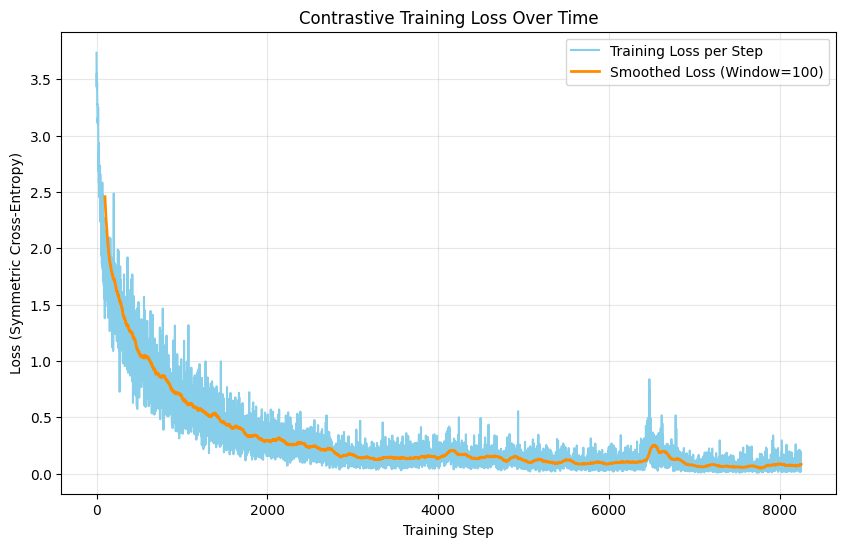

In [10]:
# --- NEW CELL: Loss Plotting ---
import matplotlib.pyplot as plt

if 'step_losses' in locals() and len(step_losses) > 0:
    plt.figure(figsize=(10, 6))
    plt.plot(step_losses, label='Training Loss per Step', color='skyblue')
    
    # Optional: Plot a smoothed line to show the trend clearer
    window_size = 100 
    if len(step_losses) > window_size:
        smoothed_losses = pd.Series(step_losses).rolling(window=window_size).mean()
        plt.plot(smoothed_losses, label=f'Smoothed Loss (Window={window_size})', color='darkorange', linewidth=2)
    
    plt.title('Contrastive Training Loss Over Time')
    plt.xlabel('Training Step')
    plt.ylabel('Loss (Symmetric Cross-Entropy)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

else:
    print("Run the training cell first to populate 'step_losses'.")